<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/%5Cnotebooks%5C04.04-Lunar_Lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
try: 
  import control as ct
except:
  !pip install control
  import control as ct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 5.1 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=39ca281b33fc17e2224625f698fa08b1f47d643758938f9f3d33d61b057561d0
  Stored in directory: /root/.cache/pip/wheels/48/ef/c2/929bb5c59a1328df00a0561d0e68cd7c8537f33f5ce0ce741b
Successfully built control


#Plant model

# Lunar lander dynamics

To develop a mathematical model we start with a force and torque balance for the lunar lander. Let $p_x$ be the horizontal position, $v_x$ be the horizontal speed, $p_y$ be the vertical position, $v_y$ be the vertical speed, $\theta$ be the heading, $v_{\theta}$ be the heading speed, using Newton’s second law and the free body diagram shown below, we can derive the following equations of motion:

\begin{align*}
\frac{dp_x}{dt} & = v_x \\
\frac{dv_x}{dt} & = \frac{F_l\cos(\theta) - F_t\sin(\theta)}{m_t} \\
\frac{dp_y}{dt} & = \left\{ 
  \begin{array}{ c l }
    v_y & \quad \textrm{if } p_y \gt 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right. \\
\frac{dv_y}{dt} & = \left\{ 
  \begin{array}{ c l }
    \frac{F_l\sin(\theta) - F_t\cos(\theta)}{m_t} - g & \quad \textrm{if } p_y \gt 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right. \\
\frac{d\theta}{dt} & = v_\theta \\
\frac{dv_\theta}{dt} & = \frac{4F_l}{J} \\
\end{align*}

and the following auxiliary equations and constraints:

\begin{align*}
c_f & = \left\{ 
  \begin{array}{ c l }
    \frac{F_t + |F_l| }{I_{sp}} & \quad \textrm{if } p_ym_f \gt 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right. \\
\frac{dm_t}{dt} & = -c_f \\
\frac{dm_f}{dt} & = -c_f \\
\end{align*}

\begin{align*}
0 \leq F_t \leq F_{t,max} \\
-F_{l,max} \leq F_l \leq F_{l,max} \\
\end{align*}

where $F_l$ is the lateral engine thurst, $F_t$ is the main engine thurst, $m_t$ is the total mass, $J$ the moment of inertia, $I_{sp}$ is the lateral and main engine specific impulse, $c_f$ is the fuel consumption and $m_f$ be the fuel mass.

 of the lunar module, $F_m$ the maximum thurst generated by the descent stage rocket engine, $u$ the descent stage rocket engine throttle, and $g$ the moon gravity acceleration.



In [1]:
def lunar_update(t, x, u, params={}):
  """Lunar lander dynamics
    Parameters
    ----------
    x: array
         System state: p_x     horizontal position [m]
                       v_x     horizontal speed    [m/s]
                       p_y     vertical position   [m]
                       v_y     vertical speed      [m/s]
                       theta   heading             [rad]
                       v_theta heading speed       [rad/s]
                       m_t     total mass          [kg]
                       m_f     fuel mass           [kg]
        
    u: array
         System input: F_t   main engine thrust    [N]
                       F_l   lateral engine thrust [N]
  
    Returns
    -------
    y: array
         The time derivatives of p_x, v_x, p_y, v_y, theta, v_theta, m_t and m_f
    """   

  # Set up the system parameters
  # Source: https://web.aeromech.usyd.edu.au/AMME3500/Course_documents/material/tutorials/Assignment%204%20Lunar%20Lander%20Solution.pdf
  J       = params.get('J',      100.0e+03) # moment of inertia           [kg m2]
  F_t_max = params.get('F_t_max', 44.0e+03) # main engine max thrust      [N]
  F_l_max = params.get('F_l_max',  0.5e+03) # lateral engine max thrust   [N]
  I_sp    = params.get('I_sp',     3.0e+03) # thruster specific impulse   [N/(kg/s)]
  g       = params.get('g',        1.6)     # moon gravitational constant [m/s2]

  #p_x_0  =   0.5e+03 # initial horizontal position  [m]
  #p_y_0  = 160.0e+03 # initial vertical position    [m]
  #v_y_0  =  -0.7e+03 # initial vertical speed       [m/s]
  #m_t_0  =  15.0e+03 # initial total mass           [kg]
  #m_f_0  =   8.0e+03 # initial fuel mass            [kg]

  p_x     = x[0] # horizontal position [m]
  v_x     = x[1] # horizontal speed    [m/s]
  p_y     = x[2] # vertical position   [m]
  v_y     = x[3] # vertical speed      [m/s]
  theta   = x[4] # heading             [rad]
  v_theta = x[5] # heading speed       [rad/s]
  m_t     = x[6] # total mass          [kg]
  m_f     = x[7] # fuel mass           [kg]
 
  F_t = u[0] # main engine thrust    [N]
  F_l = u[1] # lateral engine thrust [N]

  # Define the auxiliary equations
  F_t = np.clip(F_t, 0, F_t_max)
  F_l = np.clip(F_l, -F_l_max, F_l_max)
  c_f = (F_t + np.abs(F_l))/I_sp if p_y*m_f > 0 else 0

  # Define the ODEs
  p_xdot     = v_x
  v_xdot     = (F_l*np.cos(theta) - F_t*np.sin(theta))/m_t
  p_ydot     = v_y if p_y > 0 else 0
  v_ydot     = (F_l*np.sin(theta) + F_t*np.cos(theta))/m_t - g if p_y > 0 else 0
  thetadot   = v_theta
  v_thetadot = 4*F_l/J
  m_tdot     = -c_f
  m_fdot     = -c_f
 
  return [p_xdot, v_xdot, p_ydot, v_ydot, thetadot, v_thetadot, m_tdot, m_fdot]

In [4]:
def lunar_update(t, x, u, params={}):
  """Apollo Lunar Module dynamics update function
    Parameters
    ----------
    x: array
         System state: h, altitude of the lunar module [m]
                       v, vertical speed of the lunar module [m/s]
                       m, mass of the lunar module [kg]
        
    u: array
         System input: u, descent stage engine throttle [0-1]
  
    Returns
    -------
    y: array
         The time derivatives of h, v and m
    """   

  # Set up the system parameters
  # Source: https://nssdc.gsfc.nasa.gov/nmc/spacecraft/display.action?id=1969-059C

  # h_0 = 100000.0 # initial altitude [m]
  # v_0 =   1520.0 # initial vertical speed [m/s]
  # m_0 =  15103.0 # initial lunar module mass [kg]
  m_0   = params.get('m_0',  15103.0)  # initial lunar module mass [kg]
  m_dry = params.get('m_dry', 6855.0)  # initial lunar module mass [kg]
  F_m   = params.get('F_m',  44.0e03)  # maximum thurst generated by the descent stage rocket engine [N]
  v_e   = params.get('v_e',   3.0e03)  # velocity of the exhaust relative to the rocket [N/(kg/s)]
  g     = params.get('g',        1.62) # moon gravity acceleration [m/s2]

  h = x[0] # altitude of the lunar module [m]
  v = x[1] # vertical speed of the lunar module [m/s]
  m = x[2] # mass of the lunar module [kg]

  u = u[0] if x[2] > m_dry else 0  # descent stage engine throttle [0-1]

  # Define the ODEs
  dhdt = v if x[0] > 0 else 0
  dvdt = F_m*u/m - g if x[0] > 0 else 0
  dmdt = -F_m*u/v_e if x[2] > m_dry else 0
 
  return [dhdt, dvdt, dmdt]

## Input/ouput model for the lunar module

We now create an input/output model for the lunar module that takes the throttle $u$ as input and outputs the current lunar module altitude $h$, vertical speed $v$ and mass $m$.



In [5]:
io_lunar = ct.NonlinearIOSystem(lunar_update, None, inputs = ('u'), outputs = ('h', 'v', 'm'), states=('h', 'v', 'm'), name='lunar')

In [6]:
def lunar_plot(sys, x0, u, T):

  t, y = ct.input_output_response(sys, T, u, x0)

  fig, axes = plt.subplots(1, 3, figsize=(14, 6))
  ax = axes[0]
  ax.plot(t, y[0]/1000)
  ax.set_xlabel('Time $t$ [s]')
  ax.set_ylabel('Altitude $h$ [km]')
  ax.grid(True, linestyle='dotted')
  
  ax = axes[1]
  ax.plot(t, y[1])
  ax.set_xlabel('Time $t$ [s]')
  ax.set_ylabel('Vertical speed $v$ [m/s]')
  ax.grid(True, linestyle='dotted')

  ax = axes[2]
  ax.plot(t, y[2])
  ax.set_xlabel('Time $t$ [s]')
  ax.set_ylabel('Lunar module mass $m$ [kg]')
  ax.grid(True, linestyle='dotted')
  
  plt.suptitle('Lunar module dynamics')
  plt.tight_layout()

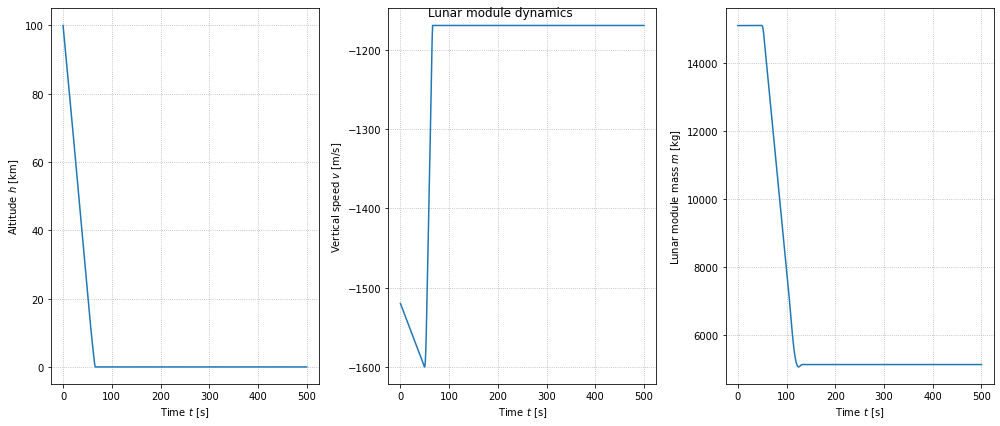

In [14]:
x0 = [100000.0, -1520.0, 15103.0]
tf = 500
T  = np.linspace(0, tf, tf+1)
u  = np.array([0 if t <= 50 else 1 for t in T])
lunar_plot(io_lunar, x0, u, T)

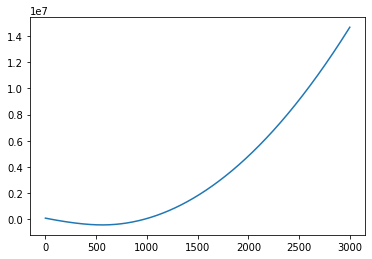

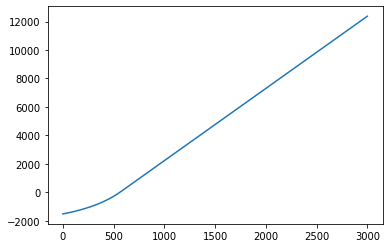

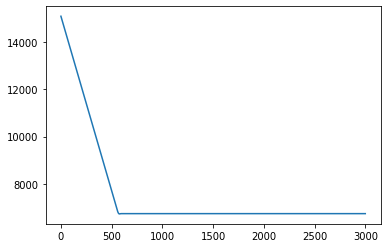

In [125]:
X0 = [100000.0, -1520.0, 15103.0] # Initial h, v, m
T = np.linspace(0, 3000, 3001)   # simulation 3000 s

# Simulate the system
t, y = ct.input_output_response(io_lunar, T, 1, X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.figure(2)
plt.plot(t, y[1])
plt.figure(3)
plt.plot(t, y[2])
#plt.legend(['Altitude', 'Vertical speed', 'Mass'])
plt.show(block=False)

## P controller

In this example, the vertical speed of the lunar module is measured and compared to the desired vertical speed. The controller is a P controller represented as a transfer function.

In [2]:
# Define the input that we want to track
T = np.linspace(0, 3000, 3001)
vref = 2 * np.ones(T.shape)

# Vary kp
subplots = [None, None]
for kp in [1, 10, 100]:
    # Create the controller transfer function (as an I/O system
    control_tf = ct.tf2io(
        ct.TransferFunction(kp, [0, 1]),
        name='control', inputs='u', outputs='y')

    # Construct the closed loop system by interconnecting process and controller
    land_tf = ct.InterconnectedSystem(
    (lunar, control_tf), name='land',
    connections = [('control.u', '-lunar.v'), ('lunar.u', 'control.y')],
    inplist = ('control.u'),
        inputs = ('vref'),
    outlist = ('lunar.v', 'lunar.u'), outputs = ('v', 'u'))

    # Plot the velocity response
    #X0, U0 = ct.find_eqpt(
    #    land_tf, [vref[0], 0], [vref[0]],
    #    iu=[1, ], y0=[vref[0], 0], iy=[0])

    t, y = ct.input_output_response(land_tf, T, [vref])
    #subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots)


NameError: ignored

In [52]:
def lunar_update(t, x, u, params={}):
  """Lunar lander dynamics
    Parameters
    ----------
    x: array
         System state: xp     vertical position   [m]
                       vx     vertical speed      [m/s]
                       yp     horizontal position [m]
                       vy     horizontal speed    [m/s]
                       theta  heading             [rad]
                       vtheta heading speed       [rad/s]
                       mt     total mass          [kg]
                       mf     fuel mass           [kg]
        
    u: array
         System input: Ft     main engine thrust    [N]
                       Fl     lateral engine thrust [N]
  
    Returns
    -------
    y: array
         The time derivatives of xp, vx, yp, vy, theta, vtheta, mt and mf
    """   

  # Set up the system parameters
  # Source: https://web.aeromech.usyd.edu.au/AMME3500/Course_documents/material/tutorials/Assignment%204%20Lunar%20Lander%20Solution.pdf
  J      = params.get('J',     100.0e+03) # moment of inertia           [kg m2]
  Ft_max = params.get('Ft_max', 44.0e+03) # main engine max thrust      [N]
  Fl_max = params.get('Fl_max',  0.5e+03) # lateral engine max thrust   [N]
  Isp    = params.get('Isp',     3.0e+03) # thruster specific impulse   [N/(kg/s)]
  g      = params.get('g',       1.6)     # moon gravitational constant [m/s2]

  #xp_0 =   0.5e+03 # initial horizontal position  [m]
  #yp_0 = 160.0e+03 # initial vertical position    [m]
  #vy_0 =  -0.7e+03 # initial vertical speed       [m/s]
  #mt_0 =  15.0e+03 # initial total mass           [kg]
  #mf_0 =   8.0e+03 # initial fuel mass            [kg]

  xp     = x[0] # horizontal position [m]
  vx     = x[1] # horizontal speed    [m/s]
  yp     = x[2] # vertical position   [m]
  vy     = x[3] # vertical speed      [m/s]
  theta  = x[4] # heading             [rad]
  vtheta = x[5] # heading speed       [rad/s]
  mt     = x[6] # total mass          [kg]
  mf     = x[7] # fuel mass           [kg]
 
  Ft = u[0] # main engine thrust    [N]
  Fl = u[1] # lateral engine thrust [N]

  # Define the auxiliary equations
  Ft = np.clip(Ft, 0, Ft_max)
  Fl = np.clip(Fl, -Fl_max, Fl_max)
  u = (Ft + np.abs(Fl))/Isp if (mf > 0) & (yp > 0) else 0

  # Define the ODEs
  xpdot     = vx
  vxdot     = (Fl*np.cos(theta) - Ft*np.sin(theta))/mt
  ypdot     = vy if yp > 0 else 0
  vydot     = (Fl*np.sin(theta) + Ft*np.cos(theta))/mt - g if yp > 0 else 0
  thetadot  = vtheta
  vthetadot = 4*Fl/J
  mtdot     = -u
  mfdot     = -u
 
  return [xpdot, vxdot, ypdot, vydot, thetadot, vthetadot, mtdot, mfdot]

In [53]:
io_lunar = ct.NonlinearIOSystem(lunar_update, None, inputs = ('Ft', 'Fl'), 
                                outputs = ('xp', 'vx', 'yp', 'vy', 'theta', 'vtheta', 'mt', 'mf'), 
                                states  = ('xp', 'vx', 'yp', 'vy', 'theta', 'vtheta', 'mt', 'mf'), 
                                name    = 'lunar')

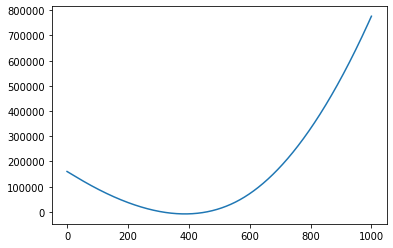

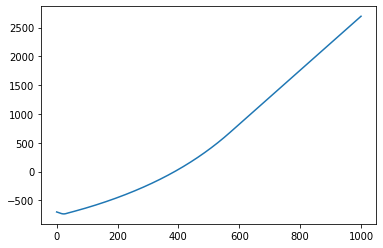

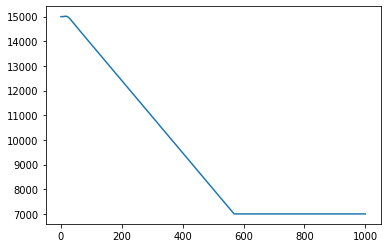

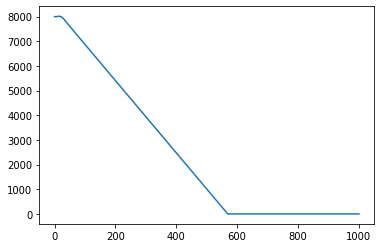

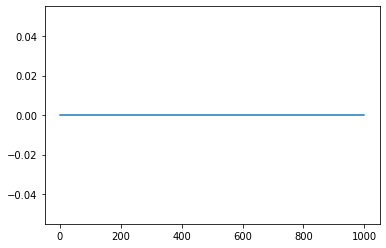

In [54]:
X0 = [0.5e+03, 0.0, 160.0e+03, -0.7e+03, 0.0, 0.0, 15.0e+03, 8.0e+03]
tf = 1000
T  = np.linspace(0, tf, tf+1)
Ft  = np.array([0 if t <= 25 else 44.0e+03 for t in T])

# Simulate the system
t, y = ct.input_output_response(io_lunar, T, [Ft, 0*0.5e+03], X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[2])
plt.figure(2)
plt.plot(t, y[3])
plt.figure(3)
plt.plot(t, y[6])
plt.figure(4)
plt.plot(t, y[7])
plt.figure(5)
plt.plot(t, y[4])
#plt.legend(['Altitude', 'Vertical speed', 'Mass'])
plt.show(block=False)